<a href="https://colab.research.google.com/github/MoSkibidi/The_Art_Of_Computer_System/blob/main/joy_compiler_phase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# การพัฒนา Joy Compiler (เฟส 4)

เฟสสุดท้ายนี้เป็นการพัฒนา Joy 3.0 เพื่อให้เป็นภาษาชั้นสูงที่มีฟีเจอร์พื้นฐานเทียบเท่ากับภาษาชั้นสูงทั่วไป โดยมีฟีเจอร์ดังนี้
* รองรับการสร้างและการเรียกใช้งานฟังก์ชัน<u>แบบไม่รีเคอร์ซีฟ</u> รวมถึงการตรวจสอบความถูกต้องของการเรียกฟังก์ชัน
* รองรับการอ้างถึงตัวแปรทั้งแบบ local และ global scope
* รองรับตัวดำเนินการคูณและหาร: `*`, `/`, `%` โดยนิยามโค้ดประมวลผลนิพจน์เหล่านี้ในรูป Joy runtime แทนการใช้ภาษาแอสเซมบลี้
* รองรับการกำหนดลำดับความสำคัญของตัวดำเนินการ (operator precedence)

เหมือนที่ผ่านมา เราจะสร้าง Joy 3.0 โดยต่อยอดจาก Joy 2.0 ให้ป้อน file id ของ colab notebook ที่ใช้ในงาน Joy 2.0 ด้านล่าง และรันเซลล์ที่เหลือเพื่อดาวน์โหลดและอิมพอร์ต Joy 2.0 มาใช้ในโน้ตบุ๊คนี้

In [ ]:
JOY20_COLAB_FILE_ID = '1CcGOyO8wjnzUUwzC4ZA1IhMq7w_fZqvp' # แก้ไขให้เป็น file id ของ Colab Notebook Joy 2.0 ของตนเอง

In [ ]:
%%capture
!pip install PyDrive import-ipynb

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':JOY20_COLAB_FILE_ID})
downloaded.GetContentFile('joy20.ipynb')

ขั้นตอนด้านล่างอาจใช้เวลาค่อนข้างนาน เนื่องจากการอิมพอร์ทเกิดขึ้นซ้อนกันหลายชั้น

In [ ]:
%%capture
import import_ipynb
from joy20 import (
    draw, listing, assemble, simulate, assemble_and_simulate,
    Joy20, TestJoy20, run_test)

รันตัวทดสอบ Joy 2.0 เพื่อให้มั่นใจว่ากระบวนการอิมพอร์ตทำได้ถูกต้อง

In [ ]:
run_test(TestJoy20)

.......................................
----------------------------------------------------------------------
Ran 39 tests in 9.887s

OK


# Joy 2.1 - Variable scopes

Joy 2.1 ยังไม่มีการเพิ่มเติมฟีเจอร์ใหม่ใด ๆ ให้ตัวภาษา แต่มีการปรับเปลี่ยนโครงสร้างภายในของโค้ดเจเนอเรเตอร์ให้พร้อมรองรับการใช้งานตัวแปรภายในฟังก์ชันทั้งในรูปแบบโลคอลและโกลบอล

กลไกนี้อาศัยตัวแปรสมาชิกที่สำคัญสองตัวได้แก่
* `_scope` เก็บชื่อฟังก์ชันปัจจุบันที่กำลังได้รับการแปลโดยคอมไพเลอร์ ณ ขณะนั้น หรือค่า None หากคอมไพเลอร์กำลังแปลโค้ดอื่นภายนอกฟังก์ชัน
* `_globals` เก็บรายการชื่อตัวแปรที่มีการประกาศให้เป็นโกลบอลที่หัวฟังก์ชัน (ด้วยคีย์เวิร์ด `global` ที่จะเพิ่มเติมลงในแกรมมาร์ต่อไป) นิยามไว้เป็นเซ็ตเพื่อให้ง่ายต่อการตรวจสอบรายชื่อ หากคอมไพเลอร์กำลังแปลโค้ดนอกฟังก์ชัน ตัวแปร `_globals` นี้ควรเป็นเซ็ตว่าง

เมท็อด `get_var_label(var)` นิยามไว้เพื่อความสะดวกในการสร้างลาเบลให้ตัวแปรในโค้ดภาษาแอสเซมบลี้ โดยเมท็อดนี้จะเช็คว่า ณ ขณะนั้นตัวแปร `var` ที่อ้างถึงในโค้ด Joy จัดเป็นตัวแปรแบบโลคอลหรือโกลบอล และเพิ่มคำนำหน้าลาเบลให้สอดคล้องกันดังนี้
* ตัวแปรโกลบอล (เงื่อนไขคือ `_scope` เป็น None หรือตัวแปร `var` ปรากฏในเซ็ต `_globals`) ให้สร้างลาเบลให้ตัวแปรในรูป `.global.var`
* ตัวแปรโลคอล (เงื่อนไขคือ `_scope` เป็นชื่อฟังก์ชัน และตัวแปร `var` ไม่ปรากฏในเซ็ต `_globals`)
สร้างลาเบลให้ตัวแปรในรูป `.local.<ชื่อฟังก์ชัน>.var`

หากมีการเรียกเมท็อดนี้ในรูป `get_var_label(id, func=<ชื่อฟังก์ชัน>)` จะมีการสร้างลาเบลให้ตัวแปร `var` ในรูปโลคอลเสมอ ไม่ว่าจะกำลังคอมไพล์อยู่ในสโคปใดก็ตาม เราจะนำรูปแบบนี้ไปใช้ในการส่งค่าอาร์กิวเมนต์ไปให้กับพารามิเตอร์ของฟังก์ชัน (พารามิเตอร์ของฟังก์ชันถือเป็นตัวแปรแบบโลคอล)

และสุดท้ายเราต้องแก้ไขเมท็อดสำหรับประมวลผลทุกกฎที่มีชื่อตัวแปรเป็นส่วนประกอบ ซึ่งได้แก่
* กฎ `stmt_assign` (คำสั่ง `let <ตัวแปร> = ...`)
* กฎ `expr_id` (นิพจน์ในรูปตัวแปรโดด)
* กฎสำหรับตัวดำเนินการ `&` (reference address)

โค้ดด้านล่างดำเนินการทุกอย่างให้แล้ว ยกเว้นเมท็อดจัดการกฎสำหรับตัวดำเนินการ `&` ที่นิสิตเป็นผู้สร้างเอาไว้เองตั้งแต่ Joy 1.3 นิสิตจึงต้องแก้ไขเมท็อดนี้ด้วยตนเอง

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy21(Joy20):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._scope = None
        self._globals = set()

    def get_var_label(self, var, func=None):
        if func is not None:
            return f'.local.{func}.{var}'
        elif self._scope == None or var in self._globals:
            return f'.global.{var}'
        else:
            return f'.local.{self._scope}.{var}'

    def stmt_assign(self, tree):
        [id, expr] = tree.children
        self.visit(expr)
        self.gen_move(self.get_var_label(id), 'THIS')

    def expr_id(self, tree):
        [id] = tree.children
        self.gen_move('THIS', self.get_var_label(id))

    def expr_ref(self,tree) :
      [id] = tree.children
      self.get_var_label(id)
      self._asm.append(f'''
      D=A
      @THIS
      M=D
      ''')


    # แก้ไขเมท็อดที่สร้างโค้ดสำหรับตัวดำเนินการ & ใน Joy 1.3
    # *** ใส่โค้ดของตนเอง ***


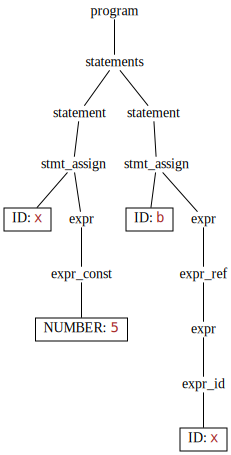

In [ ]:
x = '''
            let x = 5;
            let b = &x;
'''
tree = Joy21().parse(x)
draw(tree)

In [ ]:
asm = Joy21().compile(x)
assemble_and_simulate(asm)

## Test cases

In [ ]:
# DO NOT MODIFY

class TestJoy21(TestJoy20):
    JOY_COMPILER = Joy21

run_test(TestJoy21)

.......................................
----------------------------------------------------------------------
Ran 39 tests in 4.333s

OK


# Joy 2.2 - Functions

ฟีเจอร์หลักเพียงหนึ่งเดียวของ Joy 2.2 ที่เพิ่มขึ้นมาจาก Joy 2.1 คือการรองรับการนิยามและเรียกใช้ฟังก์ชัน ฟังก์ชันอาจนิยามไว้ที่ส่วนใดของโค้ดก็ได้ แต่ต้องนิยามไว้ก่อนหน้าการเรียกใช้งานเสมอ

### การนิยามฟังก์ชัน
ใช้คีย์เวิร์ด `def` ซึ่งมีโครงสร้างดังนี้

```
def func_name(param1, param2, ...) {
    global global_var1;
    global global_var2;
        :
    statement1;
    statement2;
        :
}
```

ตัวแปรทุกตัวที่ถูกเรียกใช้ภายในฟังก์ชันจะถือเป็นตัวแปรแบบโลคอล เว้นแต่ว่ามีการประกาศให้เป็นโกลบอลด้วยคีย์เวิร์ด `global` ที่<u>ต้องวางไว้ต้นฟังก์ชันเท่านั้น </u>ส่วนของพารามิเตอร์และการระบุตัวแปรโกลบอลอาจมีหรือไม่มีก็ได้ และคำสั่งในฟังก์ชันอาจอยู่ในรูป `return` *expr* เพื่อออกจากฟังก์ชันและคืนค่า *expr* กลับไปยังผู้เรียก

### การเรียกฟังก์ชัน
ใช้คำสั่งในรูป

```
func_name(arg1, arg2, ...)
```
ซึ่งตีความได้ทั้งเป็นนิพจน์ (expression) หรือเป็นคำสั่ง (statement) ก็ได้

### ปรับแก้แกรมมาร์
ให้นิสิตแก้ไขแกรมมาร์ของตนเองให้รองรับการใช้งานฟังก์ชันตามที่กล่าวมา โดยเริ่มจากเปลี่ยนการนิยามกฎ `program` ให้เพิ่มการนิยามฟังก์ชันเข้าไป และสามารถสลับไปมากับ statement ปกติได้ ดังนี้ (สังเกตว่าในวงเล็บเป็น `statement` ไม่ใช่ `statements`)
```
program: (funcdef | statement)*
```

เพิ่มกฎสำหรับนิยามฟังก์ชัน รวมถึงรายการพารามิเตอร์และรายการโกลบอล ดังนี้ (สังเกตว่าทั้ง `params` และ `globals` ยอมให้ว่างเปล่าได้)
```
funcdef: "def" ID "(" params ")" "{" globals statements "}"
params: ID ("," ID)*
      |
globals: ("global" ID ";")*
```

เพิ่มให้กฎ `expr` รองรับนิพจน์เรียกฟังก์ชันดังนี้ (สังเกตว่า `args` ยอมให้ว่างเปล่าได้)
```
expr: ... // รายการที่มีอยู่แล้วของกฎ expr
    | expr_call
expr_call: ID "(" args ")"
args: expr ("," expr)*
    |
```

และสุดท้าย เพิ่มให้กฎ `statement` รองรับคำสั่งเรียกฟังก์ชันโดยไม่สนใจค่าที่คืนมา และคำสั่ง `return` ดังนี้
```
statement: ... // รายการที่มีอยู่แล้วของกฎ statement
         | stmt_call
         | stmt_return
stmt_call: expr_call ";"
stmt_return: "return" expr ";"
```

In [ ]:
def plus(a,b) :
  return a+b
a = plus(5,6)
print(a)

11


## ข้อตกลงระหว่างผู้เรียกและผู้ถูกเรียก

ในกระบวนการเรียกฟังก์ชัน ข้อมูลที่ใช้โต้ตอบกันระหว่างผู้เรียก (caller) และฟังก์ชันที่ถูกเรียก (callee) ได้แก่
* ผู้เรียกป้อนค่าของอาร์กิวเมนต์แต่ละตัวลงไปในพารามิเตอร์ของผู้ถูกเรียกโดยตรง โดยอาศัยฟังก์ชัน `get_var_label()`
* ผู้เรียกบันทึกตำแหน่งการกระโดดกลับ (return address) ไว้ในรีจีสเตอร์ `LCL` เพื่อให้ผู้ถูกเรียกใช้ในการกระโดดกลับมายังคำสั่งถัดไปของผู้เรียก อย่างไรก็ตาม เป็นไปได้ว่าผู้เรียกอาจเป็นฟังก์ชันที่ถูกเรียกโดยฟังก์ชันอื่นอีกที ดังนั้นก่อนที่จะเขียนค่าทับลงไปในรีจีสเตอร์ `LCL` ให้ push ค่า `LCL` ไว้ในสแต็กเสียก่อน แล้วจึงค่อย pop ค่า `LCL` ออกมาหลังที่กระโดดกลับมา
* เมื่อพบคำสั่ง `return` ผู้ถูกเรียกบันทึกค่าที่คืนกลับจากฟังก์ชัน (returned value) ไว้ในรีจีสเตอร์ `THIS` เพื่อส่งค่ากลับมายังผู้เรียก

โค้ดฝั่งผู้เรียก (caller) ที่คอมไพเลอร์ต้องสร้างขึ้นมาจะมีส่วนประกอบตามลำดับดังนี้

1. โค้ดคำนวณค่าของอาร์กิวเมนต์แต่ละตัว และโหลดค่าไว้ในพารามิเตอร์ของผู้ถูกเรียกที่วางอยู่ในตำแหน่งเดียวกัน
2. โค้ด push ค่า `LCL` ไว้ในสแต็ก
3. โค้ดบันทึกค่า return address ไว้ใน `LCL` ซึ่งนำมาจากลาเบลในข้อ 5 ที่จะวางเอาไว้ในตำแหน่งถัดจากคำสั่งกระโดดไปยังฟังก์ชัน
4. โค้ดกระโดดไปยังจุดเริ่มต้นของฟังก์ชันผู้ถูกเรียก
5. ลาเบลสำหรับใช้เป็น return address
6. โค้ด pop ค่า `LCL` ออกจากสแต็ก

ส่วนโค้ดฝั่งฟังก์ชันผู้ถูกเรียก (callee) ที่คอมไพเลอร์ต้องสร้างขึ้นมาจะมีส่วนประกอบตามลำดับดังนี้
1. โค้ดกระโดดข้ามโค้ดส่วนของฟังก์ชันทั้งหมดไปยังลาเบลที่วางไว้ปิดท้ายฟังก์ชันตามข้อ 6 เพื่อป้องกันไม่ให้ฟังก์ชันถูกเรียกทำงานระหว่างการนิยาม (เนื่องจากว่าเราสามารถนิยามฟังก์ชันแทรกไว้ระหว่างโค้ดคำสั่งทั่วไปได้)
2. ลาเบลระบุจุดเริ่มต้นของฟังก์ชันเพื่อให้ผู้เรียกกระโดดมาที่จุดนี้
3. โค้ดสำหรับฟังก์ชันบอดี้ ซึ่งต้องแปลชื่อตัวแปรให้สอดคล้องกับขอบเขตของตัวแปรที่อาจเป็นโลคอลหรือโกลบอลก็ได้ (ส่วนนี้ดำเนินการไปแล้วใน Joy 2.1) และถ้าคำสั่งที่พบเป็นคำสั่ง `return` จะมีการสร้างโค้ดให้กระโดดไปยังจุดเริ่มต้นโค้ดกระโดดกลับสู่ผู้เรียกในข้อ 4
4. ลาเบลสำหรับจุดเริ่มต้นโค้ดกระโดดกลับสู่ผู้เรียก ใช้เป็นจุดกระโดดให้คำสั่ง `return` ที่สามารถถูกวางไว้ที่จุดใดของฟังก์ชันก็ได้
5. โค้ดกระโดดกลับสู่ผู้เรียก ซึ่งอาศัยจากค่า return address ที่เก็บไว้ในรีจีสเตอร์ `LCL` ที่ผู้เรียกวางไว้ให้
6. ลาเบลปิดท้ายฟังก์ชัน เพื่อใช้เป็นปลายทางของการกระโดดในข้อ 1 เพื่อข้ามโค้ดฟังก์ชันไปก่อนระหว่างการนิยาม

ฟีเจอร์ของคอมไพเลอร์เกี่ยวกับฟังก์ชันอีกอย่างหนึ่งคือการตรวจสอบความถูกต้องเชิงความหมาย ซึ่งถือเป็นหน้าที่ของ semantic analysis ของคอมไพเลอร์ สิ่งที่เราจะตรวจสอบมีดังนี้

* ฟังก์ชันต้องมีการนิยามก่อนถูกเรียกใช้งาน
* ฟังก์ชันที่นิยามขึ้นต้องมีชื่อไม่ซ้ำกับฟังก์ชันที่เคยนิยามไว้แล้ว
* จำนวนอาร์กิวเมนต์ขณะเรียกฟังก์ชันต้องเท่ากับจำนวนพารามิเตอร์ที่ฟังก์ชันนิยามไว้
* คำสั่ง `return` ใช้ได้เฉพาะในฟังก์ชันเท่านั้น

นิยาม exception เพื่อใช้รายงานความผิดพลาดทั้ง 4 รายการไว้ดังนี้

In [ ]:
# raise เมื่อพบการเรียกฟังก์ชันโดยยังไม่ได้นิยาม
class JoyUndefinedFunctionException(Exception):
    pass

# raise เมื่อพบการนิยามฟังก์ชันซ้ำชื่อเดิมก่อนหน้านี้
class JoyMultiplyDefinedFunctionException(Exception):
    pass

# raise เมื่อพบว่าจำนวนอาร์กิวเมนต์ไม่ตรงกับจำนวนพารามิเตอร์
class JoyParamMismatchException(Exception):
    pass

# raise เมื่อพบคำสั่ง return นอกการนิยามฟังก์ชัน
class JoyReturnOutsideFunctionException(Exception):
    pass

ต่อไปเป็นหน้าที่ของนิสิตในการสร้างคลาส Joy 2.2 ตามแนวทางทั้งหมดที่กล่าวมาข้างต้น

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy22(Joy21):

    # วางแกรมมาร์ที่มีการปรับเปลี่ยนจาก Joy 2.0 ของตนเองให้รองรับฟังก์ชัน
    # ตามที่ระบุข้างต้นเรียบร้อยแล้ว
    # *** ใส่โค้ดของตนเอง ***
    GRAMMAR = r'''
        program: (funcdef | statement)*
        funcdef: "def" ID "(" params ")" "{" globals statements "}"
        params: ID ("," ID)*
              |
        globals: ("global" ID ";")*
        statements : statement*
        statement: stmt_assign
                 | stmt_deref
                 | stmt_if
                 | stmt_if_else
                 | stmt_while
                 | stmt_until
                 | stmt_call
                 | stmt_return
        stmt_call: expr_call ";"
        stmt_return: "return" expr ";"
        stmt_assign: "let" ID "=" expr ";"
        stmt_deref: "let" "*" expr "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        stmt_while: "while" expr "{" statements "}"
        stmt_until: "until" expr "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
            | expr_sub
            | expr_neg
            | expr_compare
            | expr_or
            | expr_and
            | expr_not
            | expr_ref
            | expr_deref
            | expr_string
            | expr_array
            | expr_bracket
            | expr_call

        expr_bracket: "(" expr ")"
        expr_array: "[" [ expr ("," expr)* [","] ] "]"
        expr_string: STRING
        expr_ref:  "&" expr
        expr_deref: "*" expr
        expr_not:  "!" expr
        expr_and: expr "&&" expr
        expr_or:  expr "||" expr
        expr_compare:  expr COMPARE expr
        expr_sub: expr "-" expr
        expr_add: expr "+" expr
        expr_neg: "-" expr
        expr_id: ID
        expr_const: NUMBER
                  | HEX
                  | BIN
                  | CHAR
        expr_call: ID "(" args ")"
        args: expr ("," expr)*
            |

        STRING: /"(\\.|[^"\\])*"/
        HEX: /0[xX][0-9A-Fa-f]+/
        BIN: /0[bB][01]+/
        CHAR: /'.?'/
        NUMBER: /-?[0-9]+/
        COMPARE: /(>=|<=|==|!=|>|<)/
        ID: /[_A-Za-z][_0-9A-Za-z]*/

        WS: /[ \t\f\r\n]+/
        COMMENT: "//" /[^\r\n]*[\r\n]?/

        %ignore COMMENT
        %ignore WS

    '''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # นิยามตัวแปรสมาชิกเพิ่มเติมตามต้องการ เช่น dict สำหรับเก็บรายการฟังก์ชันที่นิยามไปแล้ว
        # พร้อมข้อมูลพารามิเตอร์
        # *** ใส่โค้ดของตนเอง ***
        self._func = dict()

    def expr_call(self, tree):
        [funcname, args] = tree.children

        # ตรวจสอบว่าฟังก์ชันที่เรียกมีการนิยามหรือยัง
        # หากไม่มีให้สั่ง raise JoyUndefinedFunctionException()
        # *** ใส่โค้ดของตนเอง ***
        if funcname.value not in self._func.keys():
            raise JoyUndefinedFunctionException()

        # ตรวจสอบจำนวนอาร์กิวเมนต์ ซึ่งต้องเท่ากับจำนวนพารามิเตอร์
        # หากไม่เท่าให้สั่ง raise JoyParamMismatchException()
        # *** ใส่โค้ดของตนเอง ***

        if len(args.children) != len(self._func[f'{funcname.value}']) :
            raise JoyParamMismatchException()

        # สร้างโค้ดคำนวณอาร์กิวเมนต์แต่ละค่า แล้วบันทึกไว้ในพารามิเตอร์แต่ละตัวของฟังก์ชันผู้ถูกเรียก
        # (ใช้ get_var_label() แบบระบุชื่อฟังก์ชันได้)
        # *** ใส่โค้ดของตนเอง ***

        for i in range (len(args.children)) :
          x = self._func[f'{funcname.value}'][i]
          self.visit(args.children[i])
          self.gen_move(self.get_var_label(x, funcname.value), 'THIS')

        # push ค่าปัจจุบันของ LCL ลงสแต็ก
        # *** ใส่โค้ดของตนเอง ***
        label = self.gen_label_no()

        self.gen_push('LCL')

        # บันทึกค่า return address ไว้ใน LCL ซึ่งได้มาจากลาเบลที่กำลังจะ
        # วางไว้ต่อจากโค้ดกระโดดไปยังฟังก์ชัน
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'''
        @.return.{label}
        D=A
        @LCL
        M=D
        ''')

        # สร้างโค้ดกระโดดไปยังจุดเริ่มต้นของฟังก์ชันผู้ถูกเรียก
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'''
        @.{funcname.value}.start
        0;JMP
        ''')

        # วางลาเบลที่ใช้เป็น return address (ระวังอย่าให้ชื่อลาเบลซ้ำ)
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'(.return.{label})')

        # pop ค่า LCL เดิมที่เคยบันทึกไว้ออกมาจากสแต็ก
        # *** ใส่โค้ดของตนเอง ***
        self.gen_pop('LCL')

    def funcdef(self, tree):
        [funcname, params, globals, statements] = tree.children

        # ตรวจสอบว่าชื่อฟังก์ชันซ้ำกับที่เคยนิยามมาแล้วหรือไม่
        # หากพบว่าซ้ำให้สั่ง raise JoyMultiplyDefinedFunctionException()
        # *** ใส่โค้ดของตนเอง ***
        if funcname.value in self._func.keys():
            raise JoyMultiplyDefinedFunctionException()


        # ตั้ง _scope ให้เป็นชื่อฟังก์ชัน
        self._scope = funcname.value

        # เก็บรายชื่อตัวแปรโกลบอลลงในเซ็ต _global ที่นิยามไว้ใน ​Joy 2.1
        for g in globals.children:
            self._globals.add(g.value)

        # บันทีกข้อมูลเกี่ยวกับฟังก์ชัน เพื่อใช้ตรวจสอบในภายหลัง เช่น ชื่อฟังก์ชัน จำนวนพารามิเตอร์ ฯลฯ
        # *** ใส่โค้ดของตนเอง ***
        self._func[f'{funcname.value}'] = params.children

        # สร้างโค้ดให้กระโดดข้ามฟังก์ชันบอดี้ไปยังท้ายฟังก์ชัน
        # (เพื่อป้องกันไม่ให้ฟังก์ชันทำงานระหว่างการนิยาม)
        # *** ใส่โค้ดของตนเอง **
        self._asm.append(f'''
        @.{funcname.value}.end
        0;JMP
        ''')

        # วางลาเบลระบุจุดเริ่มต้นของฟังก์ชันเพื่อให้ผู้เรียกกระโดดมาที่จุดนี้เมื่อพบคำสั่งเรียกฟังก์ชัน
        # (ระวังอย่าให้ชื่อลาเบลซ้ำ)
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'(.{funcname.value}.start)')

        # สร้างโค้ดสำหรับบอดี้ของฟังก์ชัน (อยู่ในตัวแปร statements ที่ดึงมาจาก parse tree)
        # *** ใส่โค้ดของตนเอง ***
        for i in statements.children :
          self.visit(i)

        # วางลาเบลเพื่อใช้เป็นจุดกระโดดออกจากฟังก์ชัน
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'(.{funcname.value}.return)')

        # สร้างโค้ดกระโดดกลับไปยังผู้เรียก โดยดึง return address จาก LCL
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'''
        @LCL
        A=M
        0;JMP
        ''')

        # วางลาเบลปิดท้ายฟังก์ชันเพื่อใช้เป็นจุดกระโดดข้ามฟังก์ชันบอดี้ระหว่างการนิยามฟังก์ชัน
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'(.{funcname.value}.end)')

        # กำหนด _scope ให้เป็นโกลบอลดังเดิม และล้างรายการตัวแปรโกลบอลออกจากเซ็ต _globals
        self._scope = None
        self._globals.clear()

    def stmt_return(self, tree):
        # ตรวจสอบว่าอยู่ในสโคปของฟังก์ชันหรือไม่ หากเป็นโกลบอลสโคป (_scope เป็น None)
        # ให้สั่ง raise JoyReturnOutsideFunctionException()
        if self._scope == None:
            raise JoyReturnOutsideFunctionException()

        # สร้างโค้ดประมวลผลค่า expr ซึ่งผลลัพธ์จะต้องอยู่ในรีจีสเตอร์ THIS ตามที่ต้องการอยู่แล้ว
        # *** ใส่โค้ดของตนเอง ***
        [expr] = tree.children
        self.visit(expr)

        # สร้างโค้ดกระโดดไปยังลาเบลที่เตรียมออกจากฟังก์ชัน
        # *** ใส่โค้ดของตนเอง ***
        self._asm.append(f'''
        @.{self._scope}.return
        0;JMP
        ''')


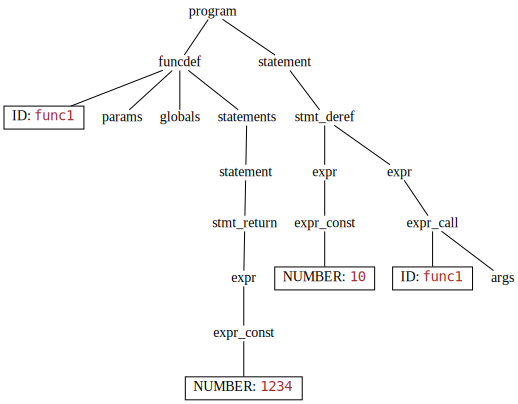

[Tree(Token('RULE', 'funcdef'), [Token('ID', 'func1'), Tree(Token('RULE', 'params'), []), Tree(Token('RULE', 'globals'), []), Tree(Token('RULE', 'statements'), [Tree(Token('RULE', 'statement'), [Tree(Token('RULE', 'stmt_return'), [Tree(Token('RULE', 'expr'), [Tree(Token('RULE', 'expr_const'), [Token('NUMBER', '1234')])])])])])]), Tree(Token('RULE', 'statement'), [Tree(Token('RULE', 'stmt_deref'), [Tree(Token('RULE', 'expr'), [Tree(Token('RULE', 'expr_const'), [Token('NUMBER', '10')])]), Tree(Token('RULE', 'expr'), [Tree(Token('RULE', 'expr_call'), [Token('ID', 'func1'), Tree(Token('RULE', 'args'), [])])])])])]


In [ ]:
x ='''
            def func1() {
                return 1234;
            }
            let *10 = func1();
           '''

tree = Joy22().parse(x)
draw(tree)
print(tree.children)

In [ ]:
x = Joy22().compile(x)
assemble_and_simulate(x)

## Test cases

In [ ]:
# DO NOT MODIFY

class TestJoy22(TestJoy21):

    JOY_COMPILER = Joy22

    def test_func_no_arg_no_local(self):
        self.compile_and_run('''
            def func1() {
                return 1234;
            }
            let *10 = func1();
        ''')
        self.assertEqual(self.cpu.ram[10], 1234)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_no_arg(self):
        self.compile_and_run('''
            def func1() {
                let a = 2;
                return 3;
            }
            let a = 1;
            func1();
            let *10 = a;
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_args(self):
        self.compile_and_run('''
            def func1(a, b) {
                return a+b;
            }
            let a = 1;
            let b = 2;
            let *10 = func1(10, 20);
            let *11 = a;
            let *12 = b;
        ''')
        self.assertEqual(self.cpu.ram[10], 30)
        self.assertEqual(self.cpu.ram[11], 1)
        self.assertEqual(self.cpu.ram[12], 2)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_globals1(self):
        self.compile_and_run('''
            def func1(a, b) {
                global g;
                let g = 30;
                return a+b;
            }
            let a = 1;
            let b = 2;
            let g = 0;
            let *10 = func1(10, 20);
            let *11 = a;
            let *12 = b;
            let *13 = g;
        ''')
        self.assertEqual(self.cpu.ram[10], 30)
        self.assertEqual(self.cpu.ram[11], 1)
        self.assertEqual(self.cpu.ram[12], 2)
        self.assertEqual(self.cpu.ram[13], 30)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_globals2(self):
        self.compile_and_run('''
            def func1() {
                global g1;
                let g1 = 1;  // global
                return 0;
            }
            def func2() {
                global g2;
                let g1 = 2;  // local
                return 0;
            }
            let g1 = 10;
            let g2 = 20;
            func1();
            func2();
            let *10 = g1;
            let *11 = g2;
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[11], 20)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_no_return(self):
        self.compile_and_run('''
            def func1() {
                global x;
                let x = 123;
            }

            func1();
            let *10 = x;
        ''')
        self.assertEqual(self.cpu.ram[10], 123)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_mid_return(self):
        self.compile_and_run('''
            def func1(x) {
                if x < 10 { return 1;}
                else { return 2; }
            }

            let *10 = func1(5);
            let *11 = func1(15);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[11], 2)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_chained_call(self):
        self.compile_and_run('''
            def f(x) {
                return x+2;
            }
            def g(y) {
                return f(y)+5;
            }

            let *10 = g(10);
        ''')
        self.assertEqual(self.cpu.ram[10], 17)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_nested_call(self):
        self.compile_and_run('''
            def f(x) {
                return x+2;
            }
            def g(x) {
                return 50-x;
            }

            let *10 = f(g(30));
        ''')
        self.assertEqual(self.cpu.ram[10], 22)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_func_nested_call2(self):
        self.compile_and_run('''
            def f(x) {
                return x+2;
            }
            let *10 = f(f(30));
        ''')
        self.assertEqual(self.cpu.ram[10], 34)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_undefined_func(self):
        with self.assertRaises(JoyUndefinedFunctionException):
            self.compile_and_run('''
                def func1(a, b) {
                    return a+b;
                }
                let a = func2();
            ''')

    def test_param_mismatch(self):
        with self.assertRaises(JoyParamMismatchException):
            self.compile_and_run('''
                def func1(a, b) {
                    return a+b;
                }
                let a = func1();
            ''')

    def test_multiply_defined(self):
        with self.assertRaises(JoyMultiplyDefinedFunctionException):
            self.compile_and_run('''
                def func1(a, b) {
                    return a+b;
                }
                def func1() {
                    return 3;
                }
                let a = func1();
            ''')

    def test_return_outside_func(self):
        with self.assertRaises(JoyMultiplyDefinedFunctionException):
            self.compile_and_run('''
                def func1(a, b) {
                    return a+b;
                }
                def func1() {
                    return 3;
                }
                let a = func1();
                return 0;
            ''')

run_test(TestJoy22)

.....................................................
----------------------------------------------------------------------
Ran 53 tests in 6.906s

OK


# Joy 2.3 - Mul/div and Joy runtime

Joy 2.3 เพิ่มฟีเจอร์ให้รองรับตัวดำเนินการ `*` (คูณ) `/` (หารเอาผลลัพธ์จำนวนเต็ม) และ `%` (หารเอาเศษ)

ให้นิสิตเพิ่มกฎต่อไปนี้ลงในแกรมมาร์ของตนเองในคลาส Joy23 ด้านล่าง

```
expr: ...  // รายการที่มีอยู่แล้วของกฎ expr
    | expr_muldiv
expr_muldiv: expr MULDIV_OP expr

MULDIV_OP: "*" | "/" | "%"
```

การสร้างโค้ดให้ตัวดำเนินการเหล่านี้โดยตรงในภาษาแอสเซมบลี้ค่อนข้างซับซ้อน เราจะอาศัยกลไกของฟังก์ชันจาก Joy 2.2 เพื่อสร้างโค้ดในภาษา Joy
ในรูปฟังก์ชัน `_mul()` `_div()` และ `_mod()` ซึ่งสะดวกกว่าการเขียนด้วยแอสเซมบลี้มาก ฟังก์ชันเหล่านี้ถูกดึงมาคอมไพล์ร่วมกับโค้ดปกติ จึงอาจเรียกได้ว่าเป็น *Joy runtime library*

เมื่อมีการประมวลผลนิพจน์ที่ใช้ตัวดำเนินการเหล่านี้ เราจะดัดแปลงโครงสร้างพาร์ชทรีให้อยู่ในรูปการเรียกฟังก์ชัน เพื่อให้กลไกการเรียกฟังก์ชันที่มีอยู่แล้วดำเนินการต่อไป

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

from lark import Tree, Token

class Joy23(Joy22):

    # ปรับปรุงแกรมมาร์จาก Joy 2.2 โดยเพิ่มกฎสำหรับนิพจน์ *, /, % ตามที่อธิบายไว้ข้างต้นให้เรียบร้อย
    # *** ใส่โค้ดของตนเอง ***
    GRAMMAR = r'''
        program: (funcdef | statement)*
        funcdef: "def" ID "(" params ")" "{" globals statements "}"
        params: ID ("," ID)*
              |
        globals: ("global" ID ";")*
        statements : statement*
        statement: stmt_assign
                 | stmt_deref
                 | stmt_if
                 | stmt_if_else
                 | stmt_while
                 | stmt_until
                 | stmt_call
                 | stmt_return
        stmt_call: expr_call ";"
        stmt_return: "return" expr ";"
        stmt_assign: "let" ID "=" expr ";"
        stmt_deref: "let" "*" expr "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        stmt_while: "while" expr "{" statements "}"
        stmt_until: "until" expr "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
            | expr_sub
            | expr_neg
            | expr_compare
            | expr_or
            | expr_and
            | expr_not
            | expr_ref
            | expr_deref
            | expr_string
            | expr_array
            | expr_bracket
            | expr_call
            | expr_muldiv

        expr_muldiv: expr MULDIV_OP expr
        expr_bracket: "(" expr ")"
        expr_array: "[" [ expr ("," expr)* [","] ] "]"
        expr_string: STRING
        expr_ref:  "&" expr
        expr_deref: "*" expr
        expr_not:  "!" expr
        expr_and: expr "&&" expr
        expr_or:  expr "||" expr
        expr_compare:  expr COMPARE expr
        expr_sub: expr "-" expr
        expr_add: expr "+" expr
        expr_neg: "-" expr
        expr_id: ID
        expr_const: NUMBER
                  | HEX
                  | BIN
                  | CHAR
        expr_call: ID "(" args ")"
        args: expr ("," expr)*
            |

        MULDIV_OP: "*" | "/" | "%"
        STRING: /"(\\.|[^"\\])*"/
        HEX: /0[xX][0-9A-Fa-f]+/
        BIN: /0[bB][01]+/
        CHAR: /'.?'/
        NUMBER: /-?[0-9]+/
        COMPARE: /(>=|<=|==|!=|>|<)/
        ID: /[_A-Za-z][_0-9A-Za-z]*/

        WS: /[ \t\f\r\n]+/
        COMMENT: "//" /[^\r\n]*[\r\n]?/

        %ignore COMMENT
        %ignore WS

    '''

    RUNTIME = '''
        def _mul(a, b) {
            let result = 0;
            while b {
                let result = result + a;
                let b = b-1;
            }
            return result;
        }

        def _div(a, b) {
            let result = 0;
            until a < b {
                let result = result + 1;
                let a = a-b;
            }
            return result;
        }

        def _mod(a, b) {
            until a<b {
                let a = a-b;
            }
            return a;
        }
        '''

    def expr_muldiv(self, tree):
        [expr1, op, expr2] = tree.children
        funcmap = {
            '*' : '_mul',
            '/' : '_div',
            '%' : '_mod',
        }
        func = funcmap[op]
        tree = Tree('expr_call', [
            Token('ID', func),
            Tree('args', [expr1, expr2]),
        ])
        self.visit(tree)

จากโค้ดข้างต้น พาร์ซทรีของนิพจน์ที่ใช้ตัวดำเนินการ `*` `/` หรือ `%` เช่น `3*5` เดิมจะอยู่ในรูป

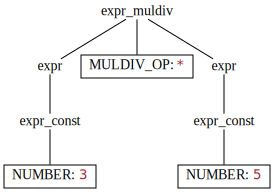

In [ ]:
tree = Joy23().parse('let a = 3*5;')
expr = tree.children[0].children[0].children[1].children[0]
draw(expr)

จะถูกนำมาสร้างเป็นทรีต้นใหม่ที่ใช้โหนด `expr_call` แทนดังนี้ เพื่อให้เมท็อด `expr_call()` จัดการแปลงโค้ดให้อยู่ในรูปการเรียกใช้ฟังก์ชันต่อไป

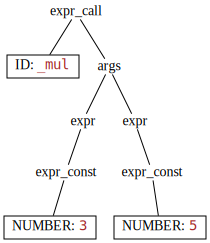

In [ ]:
[expr1, op, expr2] = expr.children
func = {'*':'_mul', '/':'_div', '%':'_mod'}[op]
newtree = Tree('expr_call', [Token('ID', func), Tree('args', [expr1, expr2])])
draw(newtree)

## Test cases

รันชุดทดสอบ (สังเกตว่าต้องมีการดึงโค้ด runtime library รวมเข้าไประหว่างการคอมไพล์ด้วย)

In [ ]:
# DO NOT MODIFY

class TestJoy23(TestJoy22):

    JOY_COMPILER = Joy23

    def test_runtime_mul(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a = 8;
            let b = 5;
            let c = 2;
            let *10 = a*(b+c);
        ''')
        self.assertEqual(self.cpu.ram[10], 56)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_runtime_div(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a = 3000;
            let b = 518;
            let *10 = a/b;
        ''')
        self.assertEqual(self.cpu.ram[10], 5)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_runtime_mod(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a = 3000;
            let b = 518;
            let *10 = a%b;
        ''')
        self.assertEqual(self.cpu.ram[10], 410)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_runtime_mix(self):
        self.compile_and_run(
            self.JOY_COMPILER.RUNTIME + '''
            let total_seconds = 3729;
            let hours = total_seconds/3600;
            let minutes = (total_seconds%3600)/60;
            let seconds = total_seconds%60;
            let *10 = hours;
            let *11 = minutes;
            let *12 = seconds;
        ''')
        self.assertEqual(self.cpu.ram[11], 2)
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[12], 9)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

run_test(TestJoy23)

.........................................................
----------------------------------------------------------------------
Ran 57 tests in 7.012s

OK


# Joy 99.0 - The End of the Line

จุดอ่อนของภาษา Joy ที่ติดมาตั้งแต่เวอร์ชันแรกคือความกำกวมของแกรมมาร์ด้านนิพจน์ แม้จะเลี่ยงได้ด้วยการใส่วงเล็บแต่ก็ขาดความสะดวก อีกทั้งมีความเสี่ยงสูงที่จะเขียนโปรแกรมผิดพลาด

Joy 99.0 จะปรับแก้ไขแกรมมาร์ในส่วนนิพจน์ให้รองรับลำดับความสำคัญของตัวดำเนินการ (operator precedence) ซึ่งกำหนดให้มีลำดับความสำคัญจากมากไปน้อยดังนี้

1. วงเล็บ `(` `)`
2. ตัวดำเนินการ `*` (dereference) `-` (ติดลบ) และ `!` (logical NOT)
3. ตัวดำเนินการ `*` (คูณ) `/` (หาร) และ `%` (หารเอาเศษ)
4. ตัวดำเนินการ `+` (บวก) และ `-` (ลบแบบไบนารี)
5. ตัวดำเนินการ `<` (น้อยกว่า) `<=` (น้อยกว่าหรือเท่ากับ) `>` (มากกว่า) `>=` (มากกว่าหรือเท่ากับ) `==` (เท่ากับ) และ `!=` (ไม่เท่ากับ)
6. ตัวดำเนินการ `&&` (logical AND)
7. ตัวดำเนินการ `||` (logical OR)

หากตัวดำเนินการมีความสำคัญเท่ากันให้ทำจาก<u>ซ้ายไปขวา</u>

## แนวทางการปรับแก้คอมไพเลอร์

ศึกษาแนวคิดและตัวอย่างจากเพจ [Precedence and associativity](http://www.cs.ecu.edu/karl/5220/spr16/Notes/CFG/precedence.html) เพื่อนิยามกฎในกลุ่มนิพจน์ใหม่เพื่อกำจัดความกำกวมออกให้หมด ทั้งนี้เราสามารถแก้ไขแกรมมาร์เพียงอย่างเดียวโดยไม่ต้องแตะต้องส่วนของโค้ดเจเนอเรชันได้ โดยให้คงชื่อกฎที่ผูกกับเมท็อดเอาไว้ดังเดิม

**หมายเหตุ:** นิสิตอาจพบว่าพาร์ซทรีที่สร้างจากแกรมมาร์ที่ปรับแก้แล้วประกอบไปด้วยสายของโหนดที่มีลูกเพียงตัวเดียวยาวต่อกันเป็นจำนวนมาก นิสิตสามารถกำหนดให้ Lark สร้างโหนดแบบ [conditinal inline](https://lark-parser.readthedocs.io/en/stable/tree_construction.html#conditionally-inlining-rules-with) เพื่อยุบโหนดเหล่านี้ออกจากพาร์ซทรีได้

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy30(Joy23):

    # แก้ไขแกรมมาร์ Joy 2.2 เพื่อให้รองรับการตีความนิพจน์ให้เป็นไปตามลำดับความสำคัญของ
    # ตัวดำเนินการตามที่กำหนดไว้ข้างต้น
    # *** ใส่โค้ดของตนเอง ***
  GRAMMAR = r"""
      program: (funcdef | statement)*
      statements: statement*

      statement: stmt_assign
              | stmt_deref
              | stmt_if
              | stmt_if_else
              | stmt_while
              | stmt_until
              | stmt_call
              | stmt_return


      stmt_assign: "let" ID "=" expr ";"
      stmt_deref:  "let" "*" expr "=" expr ";"
      stmt_if:     "if" expr "{" statements "}"
      stmt_if_else:"if" expr "{" statements "}" "else" "{" statements "}"
      stmt_while:  "while" expr "{" statements "}"
      stmt_until:  "until" expr "{" statements "}"
      stmt_call:   expr_call ";"
      stmt_return: "return" expr ";"

      funcdef: "def" ID "(" params ")" "{" globals statements "}"
      params:  ID ("," ID)* |               // zero or more
      globals: ("global" ID ";")*

      ?expr: expr_or

      // OR
      ?expr_or: expr_or "||" expr_and      -> expr_or
              | expr_and

      // AND
      ?expr_and: expr_and "&&" expr_compare -> expr_and
              | expr_compare

      // Comparisons
      ?expr_compare: expr_add COMPARE expr_add -> expr_compare
                  | expr_add

      // + and -
      ?expr_add: expr_add "+" expr_mul      -> expr_add
              | expr_add "-" expr_mul      -> expr_sub
              | expr_mul

      // *, /, %
      ?expr_mul: expr_mul MULDIV_OP expr_unary -> expr_muldiv
              | expr_unary

      // Unary ops
      ?expr_unary: "!" expr_unary           -> expr_not
                | "-" expr_unary           -> expr_neg
                | "*" expr_unary           -> expr_deref
                | "&" expr_unary           -> expr_ref
                | expr_atom

      // Atoms
      ?expr_atom: "(" expr ")"              -> expr_bracket
                | expr_call
                | expr_array
                | expr_string
                | expr_const
                | expr_id

      expr_call: ID "(" args ")"
      args: expr ("," expr)* |

      expr_array:  "[" [ expr ("," expr)* [","] ] "]"
      expr_string: STRING
      expr_id:     ID
      expr_const:  NUMBER | HEX | BIN | CHAR

      // ===== Tokens =====
      MULDIV_OP: "*" | "/" | "%"
      STRING: /"(\\.|[^"\\])*"/
      HEX:    /0[xX][0-9A-Fa-f]+/
      BIN:    /0[bB][01]+/
      CHAR:   /'.?'/
      NUMBER: /[0-9]+/
      COMPARE: /(>=|<=|==|!=|>|<)/
      ID: /[_A-Za-z][_0-9A-Za-z]*/

      WS: /[ \t\f\r\n]+/
      COMMENT: "//" /[^\r\n]*[\r\n]?/
      %ignore COMMENT
      %ignore WS
  """
  def stmt_if_else(self, tree):
    [expr, if_body,else_body] = tree.children
    label = self.gen_label_no()
    self._asm.append(f'''
        //## begin-if-{label} ##
    ''')
    self.visit(expr)
    print(self.visit(expr))
    # expr result is in THIS; if it is zero, jump over the body to the end-if label
    self._asm.append(f'''
        @THIS
        D=M
        @.endif.{label}
        D;JEQ
    ''')
    # generate the body by visiting the statements node
    self._asm.append(f'''
        //## if-body-{label} ##
    ''')
    self.visit(if_body)
    # place the end-if label here
    self._asm.append(f'''
        @THIS
        D=M
        @.endelse.{label}
        0;JMP
        //## end-if-{label} ##
        (.endif.{label})
    ''')                    #Start Else
    self._asm.append(f'''
    //##else body {label}##
    ''')
    self.visit(else_body)
    self._asm.append(f'''
    //##end else body {label}##
    (.endelse.{label})
    ''')


ตรวจสอบพาร์ซทรีที่สร้างขึ้นจากแกรมมาร์ที่แก้ไขแล้ว ให้แน่ใจว่ามีการประมวลผลตัวดำเนินการสอดคล้องกับลำดับความสำคัญที่กำหนดให้

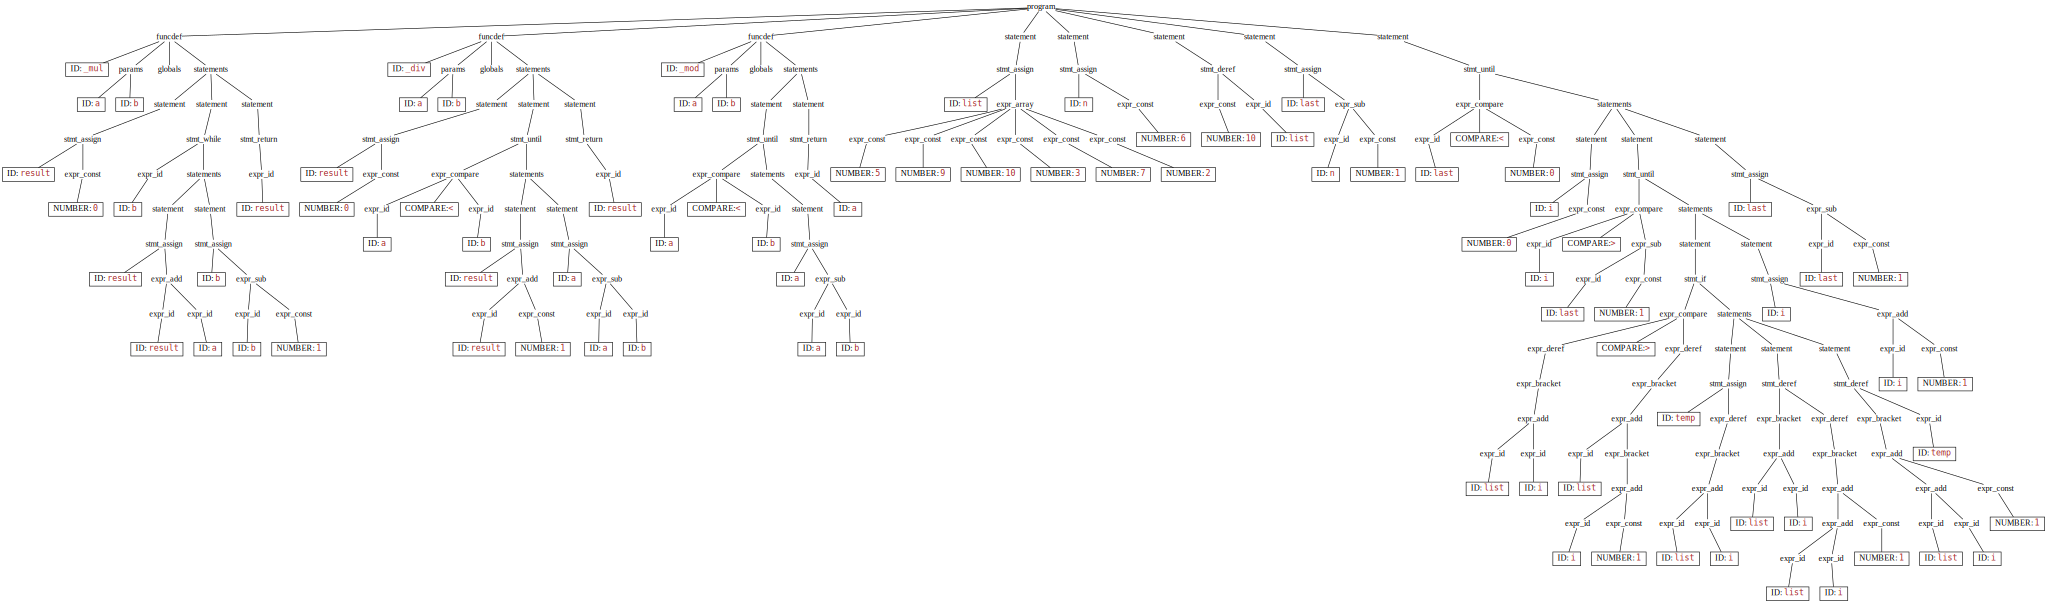

In [ ]:
x = Joy30.RUNTIME + '''
            // โค้ด bubble-sort โดย อ.เฉลิมศักดิ์
            let list = [5, 9, 10, 3, 7, 2];
            let n = 6;
            let *10 = list;
            let last = n-1;
            until last < 0 {
                let i = 0;
                until i > last-1 {
                    if *(list+i) > *(list+(i+1)) {
                        // swap list[i] and list[i+1]
                        let temp = *(list+i);
                        let *(list+i) = *(list+i+1);
                        let *(list+i+1) = temp;
                    }
                    let i = i+1;
                }
                let last = last-1;
            }
        '''
draw(Joy30().parse(x))

In [ ]:
x = Joy30().compile(x)
assemble_and_simulate(x)

## Test cases

In [ ]:
# DO NOT MODIFY

class TestJoy30(TestJoy23):

    JOY_COMPILER = Joy30

    def test_precedence_unary_over_mul(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = -5*2;
            let a2 = (-5)*2;
            let c = 50;
            let d = &c;
            let e1 = *d*2;
            let e2 = (*d)*2;
            let f1 = !0*1;
            let f2 = (!0)*1;
            let *10 = (a1==a2);
            let *11 = (e1==e2);
            let *12 = (f1==f2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[11], 1)
        self.assertEqual(self.cpu.ram[12], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_precedence_mul_over_add(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = 5+2*3+9;
            let a2 = 5+(2*3)+9;
            let b1 = 5+8/3+9;
            let b2 = 5+(8/3)+9;
            let c1 = 5+8%3+9;
            let c2 = 5+(8%3)+9;
            let *10 = (a1==a2);
            let *11 = (b1==b2);
            let *12 = (c1==c2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[11], 1)
        self.assertEqual(self.cpu.ram[12], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_precedence_add_over_compare(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = 5+2 < 7+4;
            let a2 = (5+2) < (7+4);
            let *10 = (a1==a2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_precedence_compare_over_and(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = 2 < 7 && 8 > 3;
            let a2 = (2<7) && (8>3);
            let *10 = (a1==a2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_precedence_and_over_or(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = 1 && 2 || 3 && 0;
            let a2 = (1&&2) || (3&&0);
            let *10 = (a1==a2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_precedence_left_assoc(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            let a1 = 10-3-2;
            let a2 = (10-3)-2;
            let *10 = (a1==a2);
            let b1 = 256/2/2;
            let b2 = (256/2)/2;
            let *11 = (b1==b2);
        ''')
        self.assertEqual(self.cpu.ram[10], 1)
        self.assertEqual(self.cpu.ram[11], 1)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_bubble_sort(self):
        self.compile_and_run(self.JOY_COMPILER.RUNTIME + '''
            // โค้ด bubble-sort โดย อ.เฉลิมศักดิ์
            let list = [5, 9, 10, 3, 7, 2];
            let n = 6;
            let *10 = list;
            let last = n-1;
            until last < 0 {
                let i = 0;
                until i > last-1 {
                    if *(list+i) > *(list+(i+1)) {
                        // swap list[i] and list[i+1]
                        let temp = *(list+i);
                        let *(list+i) = *(list+i+1);
                        let *(list+i+1) = temp;
                    }
                    let i = i+1;
                }
                let last = last-1;
            }
        ''')
        list_addr = self.cpu.ram[10]
        self.assertEqual(self.cpu.ram[list_addr:list_addr+6],
                         [2, 3, 5, 7, 9, 10])
        self.assertEqual(self.cpu.ram[0], 0x3fff)

run_test(TestJoy30)

................................................................
----------------------------------------------------------------------
Ran 64 tests in 7.947s

OK


# ตัวอย่างโค้ดส่งท้าย

รันโค้ดด้านล่างในซิมูเลชันและลองกดคีย์ใด ๆ (บนคีย์จำลอง) เพื่อเปลี่ยนไอคอนแสดงผลจากรูปหน้าบึ้งเป็นหน้ายิ้ม

In [ ]:
asm = Joy30().compile(Joy30.RUNTIME + '''

    let SMILE = 0;
    let SAD = 1;
    let FONT = [
        [ 0b0000011110000000,
          0b0001100001100000,
          0b0010000000010000,
          0b0100000000001000,
          0b0100100001001000,
          0b1001010010100100,
          0b1000000000000100,
          0b1000000000000100,
          0b1000100001000100,
          0b0100100001001000,
          0b0100011110001000,
          0b0010000000010000,
          0b0001100001100000,
          0b0000011110000000,
          0b0000000000000000,
          0b0000000000000000 ],

        [ 0b0000011110000000,
          0b0001100001100000,
          0b0010000000010000,
          0b0100000000001000,
          0b0101010010101000,
          0b1000100001000100,
          0b1000000000000100,
          0b1000000000000100,
          0b1000011110000100,
          0b0100100001001000,
          0b0100000000001000,
          0b0010000000010000,
          0b0001100001100000,
          0b0000011110000000,
          0b0000000000000000,
          0b0000000000000000 ]
    ];

    def draw_char(x, y, char) {
        global FONT;
        let count = 0;
        let row = 0;
        let pos = y*32*16+x;
        let glyph = *(FONT+char);
        while count < 16 {
            let *(0x4000+pos+row) = *(glyph+count);
            let count = count + 1;
            let row = row + 32;
        }
    }

    while 1 {
        if *0x6000 {
            let icon = SMILE;
            let x = 1 ;
        }
        else {
            let icon = SAD;
        }
        let count = 5;
        while count {
            draw_char(5+count, 5, icon);
            let count = count - 1;
        }
    }
''')

assemble_and_simulate(asm)

None
